## Ocean Sciences Meeting 2026

Figures for Tomy's presentation.  Explore ADCP, thermistor, and oxygen logger data around 26-28.11.2025 and 13.01.2026.

In [1]:
# imports
import ewgreaders as ewg
import xarray as xr
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm.notebook import tqdm

In [2]:
lake = 'Zugersee'
location = 'LZC'
year = '2026'
date = '20260114'

mreader = ewg.mooring_reader.MooringReader(lake, location, year, date)
mxsc, mysc =  mreader.get_swiss_coords()
bathy = xr.open_dataset(mreader.BATHY_PATH.format(lake=lake))
adcps = mreader.get_adcps()
thermistors = mreader.get_thermistors()
oxygen_loggers = mreader.get_oxygen_loggers()

# linear regression from known depths
sensor_depths = mreader.extract_sensor_depths()
m, b, _, _, _ = scipy.stats.linregress(sensor_depths.depth_md, sensor_depths.depth_sensor)
instruments = mreader.get_instruments(pandas=True)
instruments['depth_md'] = mreader.total_depth - instruments['mab']
instruments['depth_lr'] = m * instruments['depth_md'] + b

# use known depths where available
depth_table = pd.merge(instruments, sensor_depths, how='outer')
depth_table['depth'] = depth_table['depth_sensor'].fillna(depth_table['depth_lr']).round(1)
depth_table = depth_table.sort_values('depth')


Reading file Q:/Messdaten/Aphys_Hypothesis_data/Zugersee/2026/Mooring/20260114/LZC/L0\12U8315.000 ...

Reading file Q:/Messdaten/Aphys_Hypothesis_data/Zugersee/2026/Mooring/20260114/LZC/L0\3U672.000 ...

Reading file Q:/Messdaten/Aphys_Hypothesis_data/Zugersee/2026/Mooring/20260114/LZC/L0\6D1728.000 ...


C:\Users\herremha\elcres\ewgreaders\ewgreaders\readers\adcp_reader.py:81: UserWarning: No pressure measurements on ADCP, returning calculating depth from metadata.
  warnings.warn('No pressure measurements on ADCP, returning calculating depth from metadata.')



Reading file Q:/Messdaten/Aphys_Hypothesis_data/Zugersee/2026/Mooring/20260114/LZC/L0\3U16549.000 ...


### 13.1.2026

In [3]:
t_start = pd.to_datetime('2026-01-13') - pd.Timedelta(days=7)
t_end = pd.to_datetime('2026-01-14') + pd.Timedelta(hours=9)

#### ADCPs

In [4]:
all_adcp = []
for adcp in adcps:
    serial_id = adcp['serial_id']
    areader = ewg.adcp_reader.ADCPReader(serial_id, lake, location, year, date)
    fpath = areader.locate_data_file('L0')
    ds = areader.load_from_L0()
    ds = ds.expand_dims(serial_id=[ds.attrs['serialnum']])
    areader.depth = depth_table.loc[depth_table['serial_id'] == serial_id, 'depth'].iloc[0]
    ds = areader.range_to_depth(ds)
    ds['range'] = ds['range'].round(0)
    ds = areader.run_qa(ds)
    ds = ds.sel(time=slice(t_start, t_end))
    all_adcp.append(ds)

# shared time axis as mean of each instruments times
time_shared = (np.mean([ds.time.values.astype('int64') for ds in all_adcp], axis=0).astype('datetime64[ns]'))
all_adcp_aligned = [ds.assign_coords(time=time_shared) for ds in all_adcp]

# concatenate datasets and average common range bins
ds_combined = xr.concat(all_adcp_aligned, dim='range')
ds_combined = ds_combined.sortby('range')
ds_combined = ds_combined.groupby('range').mean()

# don't interplate over gap from opposite looking ADCPs in double frame
gap = np.arange(69, 73)
full_range = np.sort(np.concatenate([ds_combined.range.values, gap]))
ds_full = ds_combined.reindex(range=full_range)


Reading file Q:/Messdaten/Aphys_Hypothesis_data/Zugersee/2026/Mooring/20260114/LZC/L0\12U8315.000 ...

Reading file Q:/Messdaten/Aphys_Hypothesis_data/Zugersee/2026/Mooring/20260114/LZC/L0\3U672.000 ...

Reading file Q:/Messdaten/Aphys_Hypothesis_data/Zugersee/2026/Mooring/20260114/LZC/L0\6D1728.000 ...


C:\Users\herremha\elcres\ewgreaders\ewgreaders\readers\adcp_reader.py:81: UserWarning: No pressure measurements on ADCP, returning calculating depth from metadata.
  warnings.warn('No pressure measurements on ADCP, returning calculating depth from metadata.')



Reading file Q:/Messdaten/Aphys_Hypothesis_data/Zugersee/2026/Mooring/20260114/LZC/L0\3U16549.000 ...


C:\Users\herremha\AppData\Local\Temp\ipykernel_27964\4234817577.py:20: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'serial_id' ('serial_id',) The recommendation is to set join explicitly for this case.
  ds_combined = xr.concat(all_adcp_aligned, dim='range')


### Direction of maximal flow

In [5]:
def plot_flow_angle(df_angle):
    fig, ax = plt.subplots(figsize=(4, 6))
    palette = ['red', 'blue']

    ax.axvline(90, color='black', linestyle='--')
    sns.lineplot(df_angle, x='angle_shifted', y='range', orient='y', hue='dir', hue_order=['N', 'S'], palette=palette, 
                marker='o', markersize=5, ax=ax)

    ax.set_xlabel('Flow Angle')
    ax.set_ylabel('Depth [m]')

    ax.invert_xaxis()
    ax.invert_yaxis()
    ax.spines[['right', 'top']].set_visible(False)
    ax.grid(True)

    ax.legend(title='Flow Direction')

    plt.show()

In [6]:
# direction (angle) of maximal flow
ds_angle = ewg.lakes.flow_angle(ds_full)
df_angle = ds_angle.to_dataframe().reset_index().dropna()
df_angle['angle_shifted'] = [a - 180 if a >= 180 else a for a in df_angle['angle']]
df_angle['dir'] = ['N' if a < 180 else 'S' for a in df_angle['angle']]

# chose interface angle as average angle of flow (across all depths)
interface_angle = df_angle['angle_shifted'].mean() - 90
interface_angle

np.float64(5.661782335558854)

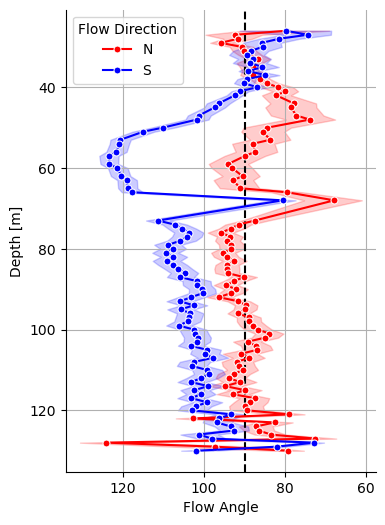

In [7]:
plot_flow_angle(df_angle)

#### Velocity time series

At angle of maximal flow.

In [8]:
def plot_velocity_ts(u_orth, v_orth, ds_temp=None, isotherms=None):
    fig, ax = plt.subplots(figsize=(10, 5))

    # velocity
    pc = (u_orth + v_orth).plot(x='time', y='range', cmap='RdBu_r', vmin=-0.1, vmax=0.1, cbar_kwargs={'label': 'Velocity [m/s]'}, ax=ax)
    pc.colorbar.ax.yaxis.label.set_size(14)

    # isotherms
    if ds_temp and isotherms:    
        for iso_t in isotherms:
            cs = ax.contour(ds_temp.time, ds_temp.depth, ds_temp.temp, levels=[iso_t], colors='black', linewidths=0.2, alpha=0.5)
            #ax.clabel(cs, inline=True, fmt=f'{temp_val}°C', fontsize=10)

    ax.set_xlabel('Time', fontsize=14, labelpad=15)
    ax.set_ylabel('Depth [m]', fontsize=14, labelpad=5)
    ax.set_title('N-S Flows Across Constriction', fontsize=14, pad=10)

    ax.invert_yaxis()
    plt.show()

In [9]:
# chose interface angle as average angle of flow (across all depths)
angle_rad = np.deg2rad(interface_angle)

u = ds_full.vel.sel(dir='E').mean(dim='serial_id')
v = ds_full.vel.sel(dir='N').mean(dim='serial_id')

# orthogonal horizontal velocities
u_orth = u * (-1) * np.sin(angle_rad)
v_orth = v * np.cos(angle_rad)

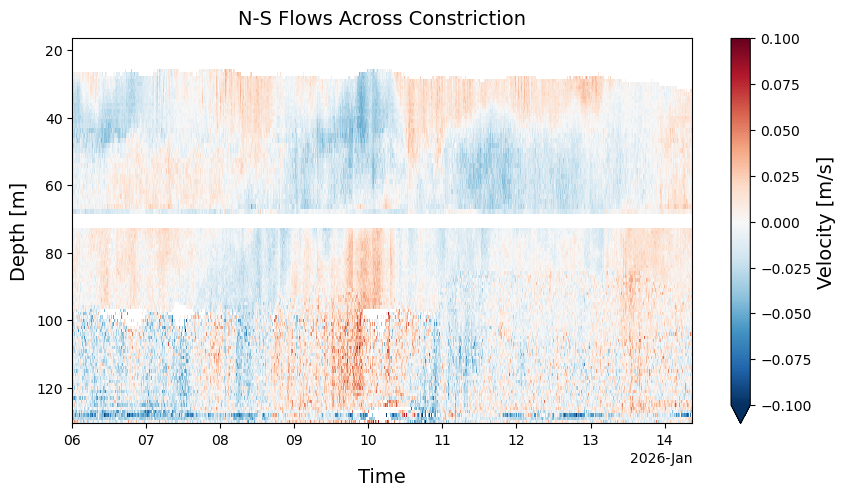

In [10]:
plot_velocity_ts(u_orth, v_orth)

### Daily net transport

In [11]:
def plot_daily_net_transport(transport_day, df_avg=None):
    fig, ax = plt.subplots(figsize=(5, 7))
    palette = ['xkcd:cerulean', 'purple', 'limegreen']

    ax.axvline(0, color='black', linestyle='--')

    # daily transport from week prior
    if isinstance(df_avg, pd.DataFrame):
        sns.lineplot(df_avg, x='transport', y='range', orient='y', hue='day', palette='Grays', alpha=0.7, ax=ax, legend=False)

    # campaign day
    sns.lineplot(transport_day, x='transport', y='range', orient='y', hue='day', palette=palette, marker='o', markersize=5, ax=ax)
    #ax.plot(transport_day.values, transport_day.range, color='xkcd:cerulean', marker='o', markersize=4)

    ax.set_xlabel('Net Volume Transport [m^3]', fontsize=14, labelpad=15)
    ax.set_ylabel('Depth [m]', fontsize=14)

    ax.spines[['right', 'top']].set_visible(False)
    ax.invert_yaxis()
    ax.grid(True)

    ax.legend(title='Campaign Date', fontsize=12, title_fontsize=12)
    plt.show()

In [12]:
flux_data = []
for d in tqdm(ds_full.range.values):
    flux = ewg.lakes.volume_flux(ds_full, d, mxsc, mysc, interface_angle, bathy)
    flux_data.append(flux.mean(dim='serial_id'))

ds_flux = xr.concat(flux_data, dim='range')

  0%|          | 0/105 [00:00<?, ?it/s]

In [13]:
# require 50% data validity
thresh = 0.5
valid_depths = ds_flux.notnull().mean(dim='time')
ds_flux = ds_flux.sel(range=valid_depths >= thresh)

# daily average week prior to campaign
dt = 600
df = ds_flux.sel(time=slice(None, '2026-01-12')).to_dataframe().reset_index()
df['transport'] = df['flux'] * dt
df['day'] = df['time'].dt.floor('D')
df_avg = df.groupby(['day', 'range'])['transport'].sum().reset_index()

# calculate net transport (campaign day)
transport_day = ewg.lakes.net_volume_transport(ds_flux.sel(time=slice('2026-01-13', '2026-01-13'))).to_dataframe().reset_index()
transport_day['day'] = '2026-01-13'

C:\Users\herremha\AppData\Local\Temp\ipykernel_27964\2183350913.py:12: UserWarning: The palette list has more values (3) than needed (1), which may not be intended.
  sns.lineplot(transport_day, x='transport', y='range', orient='y', hue='day', palette=palette, marker='o', markersize=5, ax=ax)


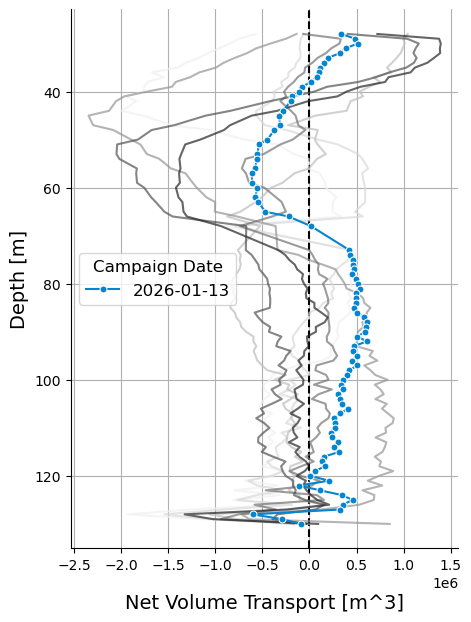

In [14]:
plot_daily_net_transport(transport_day, df_avg)

#### Thermistors

In [15]:
def plot_thermistor_ts(ds_temp):
    fig, ax = plt.subplots(figsize=(10, 5))
    im = ds_temp.temp.plot(cmap='plasma', ax=ax)

    ax.set_xlabel("Time")
    ax.set_ylabel('Depth [m]')
    im.colorbar.set_label("Temperature [°C]")

    ax.invert_yaxis()
    plt.show()

In [16]:
ds_chain = []
for t in thermistors:
    serial_id = t['serial_id']

    treader = ewg.thermistor_reader.ThermistorReader(serial_id, lake, location, year, date)
    treader.depth = depth_table.loc[depth_table['serial_id'] == serial_id, 'depth'].iloc[0]
    ds = treader.load_from_L0()
    #print(ds.depth.item())
    ds = ds.sel(time=slice(t_start, t_end))
    ds_chain.append(ds)

ds_temp = mreader.create_instrument_chain(ds_chain)

C:\Users\herremha\elcres\ewgreaders\ewgreaders\readers\mooring_reader.py:311: FutureWarning: In a future version of xarray the default value for coords will change from coords='different' to coords='minimal'. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set coords explicitly.
  return xr.concat(ds_aligned, dim='depth')


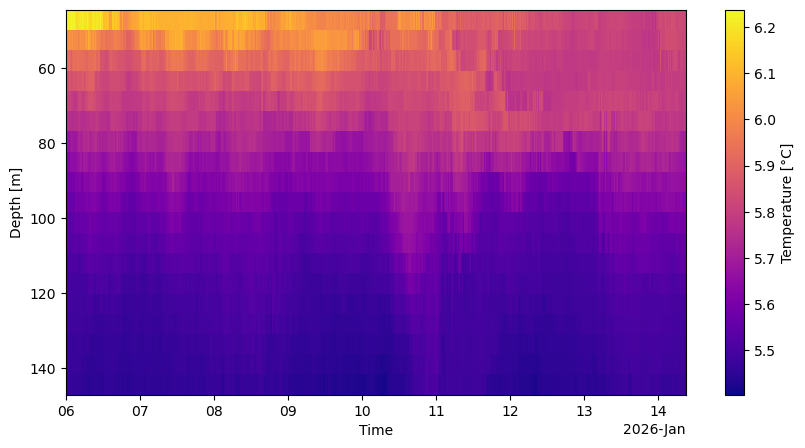

In [17]:
plot_thermistor_ts(ds_temp)

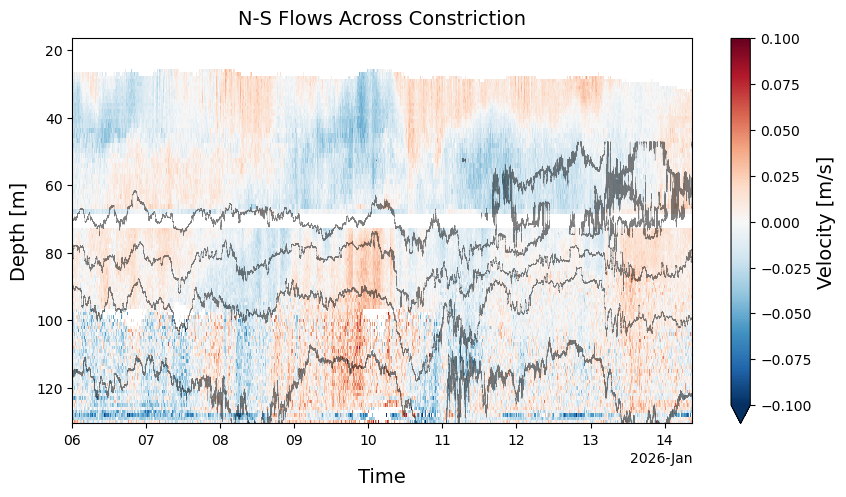

In [18]:
isotherms = [5.8, 5.7, 5.6, 5.5]
plot_velocity_ts(u_orth, v_orth, ds_temp, isotherms)

#### Oxygen loggers

In [19]:
def plot_oxygen_ts(ds_do):
    fig, ax = plt.subplots(figsize=(10, 5))
    im = ds_do.d_oxygen_conc.plot(cmap='viridis', vmin=0, ax=ax)

    ax.set_xlabel("Time")
    ax.set_ylabel('Depth [m]')
    im.colorbar.set_label("Dissolved Oxygen Concentration [µmol/L]")

    ax.invert_yaxis()
    plt.show()

In [20]:
ds_chain = []
for ol in oxygen_loggers:
    serial_id = ol['serial_id']

    oreader = ewg.o2_reader.O2Reader(serial_id, lake, location, year, date)
    fpath = os.path.join(mreader.dpath_L0, f'7450-{serial_id}/Cat.txt')
    oreader.depth = depth_table.loc[depth_table['serial_id'] == serial_id, 'depth'].iloc[0]
    ds = oreader.load_from_L0()
    ds = ds.sel(time=slice(t_start, t_end))
    ds['d_oxygen_conc'] *= (1000/32)    # conver to umol/L
    ds_chain.append(ds)

ds_do = mreader.create_instrument_chain(ds_chain)

C:\Users\herremha\elcres\ewgreaders\ewgreaders\readers\mooring_reader.py:311: FutureWarning: In a future version of xarray the default value for coords will change from coords='different' to coords='minimal'. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set coords explicitly.
  return xr.concat(ds_aligned, dim='depth')


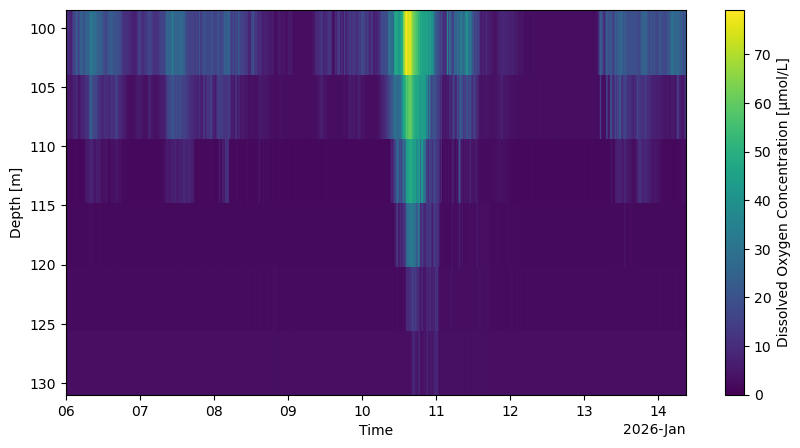

In [21]:
plot_oxygen_ts(ds_do)

### 26-28.11.2025

In [22]:
t_start = pd.to_datetime('2025-11-26') - pd.Timedelta(days=7)
t_end = pd.to_datetime('2025-11-29') + pd.Timedelta(hours=9)

#### ADCPs

In [23]:
all_adcp = []
for adcp in adcps:
    serial_id = adcp['serial_id']
    areader = ewg.adcp_reader.ADCPReader(serial_id, lake, location, year, date)
    fpath = areader.locate_data_file('L0')
    ds = areader.load_from_L0()
    ds = ds.expand_dims(serial_id=[ds.attrs['serialnum']])
    areader.depth = depth_table.loc[depth_table['serial_id'] == serial_id, 'depth'].iloc[0]
    ds = areader.range_to_depth(ds)
    ds['range'] = ds['range'].round(0)
    ds = areader.run_qa(ds)
    ds = ds.sel(time=slice(t_start, t_end))
    all_adcp.append(ds)

# shared time axis as mean of each instruments times
time_shared = (np.mean([ds.time.values.astype('int64') for ds in all_adcp], axis=0).astype('datetime64[ns]'))
all_adcp_aligned = [ds.assign_coords(time=time_shared) for ds in all_adcp]

# concatenate datasets and average common range bins
ds_combined = xr.concat(all_adcp_aligned, dim='range')
ds_combined = ds_combined.sortby('range')
ds_combined = ds_combined.groupby('range').mean()

# don't interplate over gap from opposite looking ADCPs in double frame
gap = np.arange(69, 73)
full_range = np.sort(np.concatenate([ds_combined.range.values, gap]))
ds_full = ds_combined.reindex(range=full_range)


Reading file Q:/Messdaten/Aphys_Hypothesis_data/Zugersee/2026/Mooring/20260114/LZC/L0\12U8315.000 ...

Reading file Q:/Messdaten/Aphys_Hypothesis_data/Zugersee/2026/Mooring/20260114/LZC/L0\3U672.000 ...

Reading file Q:/Messdaten/Aphys_Hypothesis_data/Zugersee/2026/Mooring/20260114/LZC/L0\6D1728.000 ...


C:\Users\herremha\elcres\ewgreaders\ewgreaders\readers\adcp_reader.py:81: UserWarning: No pressure measurements on ADCP, returning calculating depth from metadata.
  warnings.warn('No pressure measurements on ADCP, returning calculating depth from metadata.')



Reading file Q:/Messdaten/Aphys_Hypothesis_data/Zugersee/2026/Mooring/20260114/LZC/L0\3U16549.000 ...


C:\Users\herremha\AppData\Local\Temp\ipykernel_27964\4234817577.py:20: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'serial_id' ('serial_id',) The recommendation is to set join explicitly for this case.
  ds_combined = xr.concat(all_adcp_aligned, dim='range')


#### Directon of maximal flow

In [24]:
# direction (angle) of maximal flow
ds_angle = ewg.lakes.flow_angle(ds_full)
df_angle = ds_angle.to_dataframe().reset_index().dropna()
df_angle['angle_shifted'] = [a - 180 if a >= 180 else a for a in df_angle['angle']]
df_angle['dir'] = ['N' if a < 180 else 'S' for a in df_angle['angle']]

# chose interface angle as average angle of flow (across all depths)
interface_angle = df_angle['angle_shifted'].mean() - 90
interface_angle

np.float64(7.692336317860182)

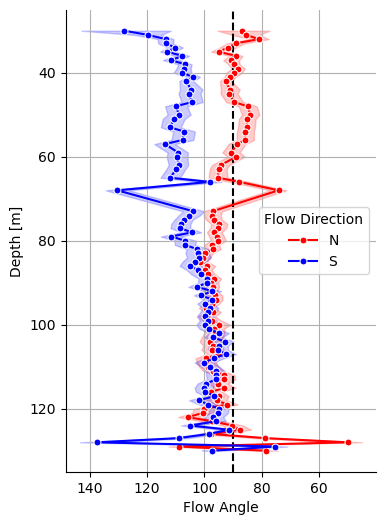

In [25]:
plot_flow_angle(df_angle)

#### Velocity time series

At angle of maximal flow.

In [26]:
# chose interface angle as average angle of flow (across all depths)
angle_rad = np.deg2rad(interface_angle)

u = ds_full.vel.sel(dir='E').mean(dim='serial_id')
v = ds_full.vel.sel(dir='N').mean(dim='serial_id')

# orthogonal horizontal velocities
u_orth = u * (-1) * np.sin(angle_rad)
v_orth = v * np.cos(angle_rad)

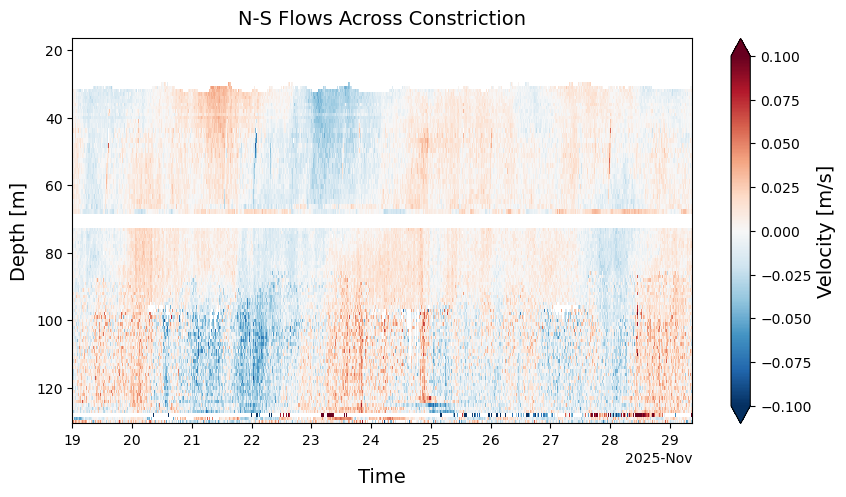

In [27]:
plot_velocity_ts(u_orth, v_orth)

### Daily net transport

In [28]:
flux_data = []
for d in tqdm(ds_full.range.values):
    flux = ewg.lakes.volume_flux(ds_full, d, mxsc, mysc, interface_angle, bathy)
    flux_data.append(flux.mean(dim='serial_id'))

ds_flux = xr.concat(flux_data, dim='range')

  0%|          | 0/105 [00:00<?, ?it/s]

In [29]:
# require 50% data validity
thresh = 0.5
valid_depths = ds_flux.notnull().mean(dim='time')
ds_flux = ds_flux.sel(range=valid_depths >= thresh)

# daily average week prior to campaign
dt = 600
df = ds_flux.sel(time=slice(None, '2025-11-25')).to_dataframe().reset_index()
df['transport'] = df['flux'] * dt
df['day'] = df['time'].dt.floor('D')
df_avg = df.groupby(['day', 'range'])['transport'].sum().reset_index()

# calculate net transport (campaign days)
transport_day1 = ewg.lakes.net_volume_transport(ds_flux.sel(time=slice('2025-11-26', '2025-11-26'))).to_dataframe().reset_index()
transport_day1['day'] = '2025-11-26'
transport_day2 = ewg.lakes.net_volume_transport(ds_flux.sel(time=slice('2025-11-27', '2025-11-27'))).to_dataframe().reset_index()
transport_day2['day'] = '2025-11-27'
transport_day3 = ewg.lakes.net_volume_transport(ds_flux.sel(time=slice('2025-11-28', '2025-11-28'))).to_dataframe().reset_index()
transport_day3['day'] = '2025-11-28'
transport_day = pd.concat([transport_day1, transport_day2, transport_day3], ignore_index=True)

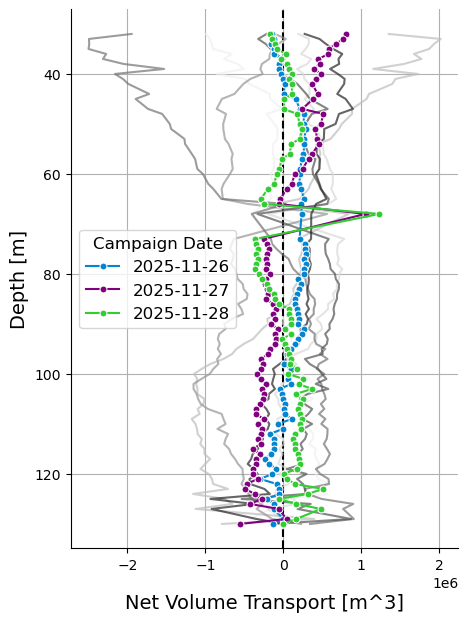

In [30]:
plot_daily_net_transport(transport_day, df_avg)

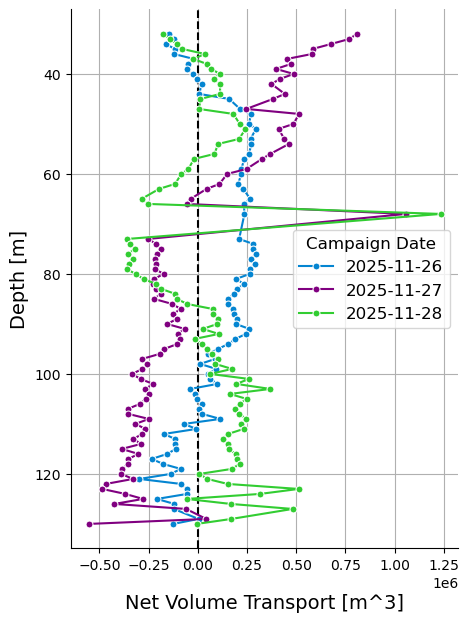

In [31]:
plot_daily_net_transport(transport_day)

#### Thermistors

In [32]:
ds_chain = []
for t in thermistors:
    serial_id = t['serial_id']

    treader = ewg.thermistor_reader.ThermistorReader(serial_id, lake, location, year, date)
    treader.depth = depth_table.loc[depth_table['serial_id'] == serial_id, 'depth'].iloc[0]
    ds = treader.load_from_L0()
    #print(ds.depth.item())
    ds = ds.sel(time=slice(t_start, t_end))
    ds_chain.append(ds)

ds_temp = mreader.create_instrument_chain(ds_chain)

C:\Users\herremha\elcres\ewgreaders\ewgreaders\readers\mooring_reader.py:311: FutureWarning: In a future version of xarray the default value for coords will change from coords='different' to coords='minimal'. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set coords explicitly.
  return xr.concat(ds_aligned, dim='depth')


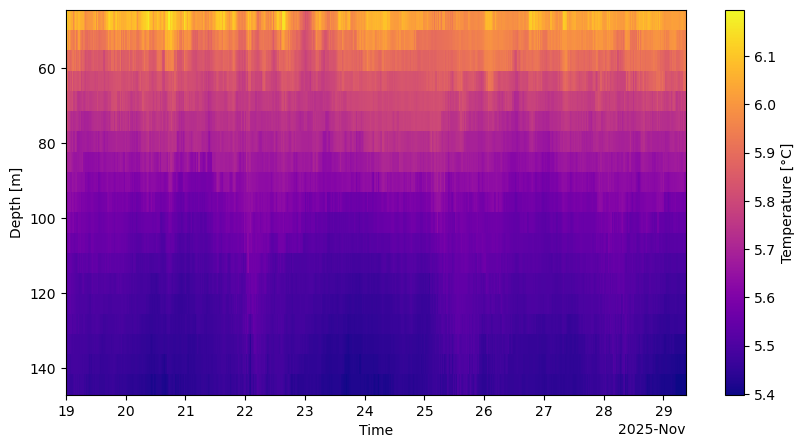

In [33]:
plot_thermistor_ts(ds_temp)

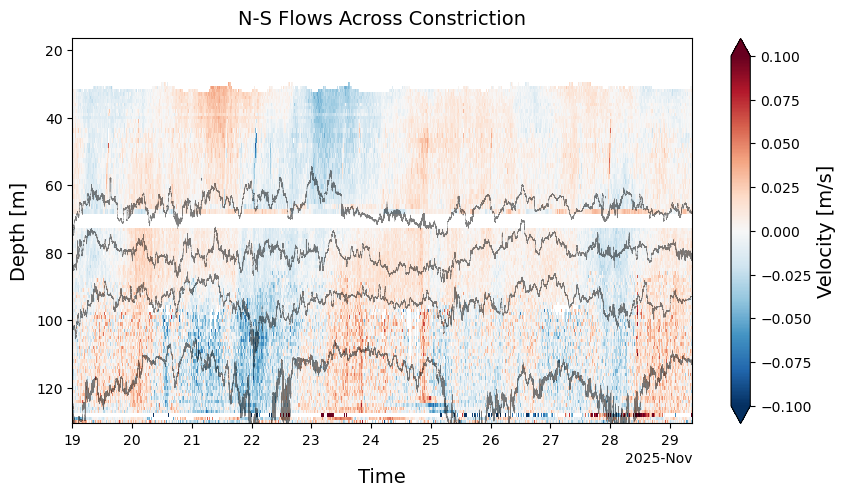

In [34]:
isotherms = [5.8, 5.7, 5.6, 5.5]
plot_velocity_ts(u_orth, v_orth, ds_temp, isotherms)

#### Oxygen loggers

In [35]:
ds_chain = []
for ol in oxygen_loggers:
    serial_id = ol['serial_id']

    oreader = ewg.o2_reader.O2Reader(serial_id, lake, location, year, date)
    fpath = os.path.join(mreader.dpath_L0, f'7450-{serial_id}/Cat.txt')
    oreader.depth = depth_table.loc[depth_table['serial_id'] == serial_id, 'depth'].iloc[0]
    ds = oreader.load_from_L0()
    ds = ds.sel(time=slice(t_start, t_end))
    ds['d_oxygen_conc'] *= (1000/32)    # conver to umol/L
    ds_chain.append(ds)

ds_do = mreader.create_instrument_chain(ds_chain)

C:\Users\herremha\elcres\ewgreaders\ewgreaders\readers\mooring_reader.py:311: FutureWarning: In a future version of xarray the default value for coords will change from coords='different' to coords='minimal'. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set coords explicitly.
  return xr.concat(ds_aligned, dim='depth')


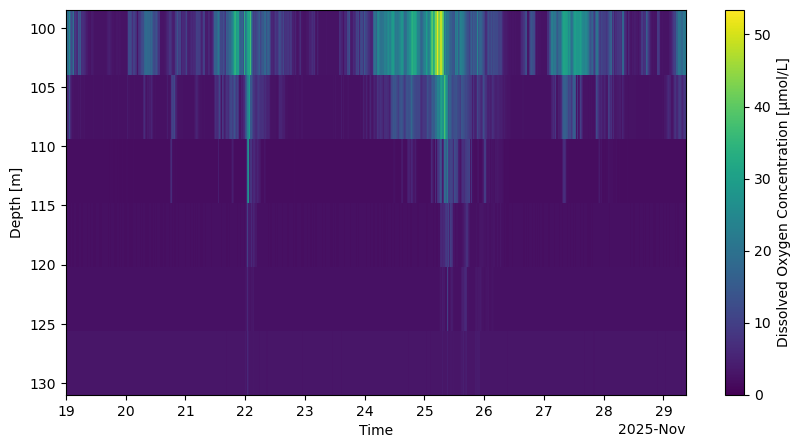

In [36]:
plot_oxygen_ts(ds_do)

### CTD

Thorpe scale and oxygen displacement lengths.

In [51]:
serial_id = '1807'
lake = 'Zugersee'
year = '2026'
date = '20260113'

dpath_L1 = f'Q:/Messdaten/Aphys_Hypothesis_data/{lake}/{year}/CTD/{date}/L1'

In [ ]:
data = []
for p in os.listdir(dpath_L1):
    fpath = os.path.join(dpath_L1, p)
    
    ctdreader = ewg.ctd_reader.CTDReader(lake, year, date, fpath, serial_id)
    bathy = ctdreader.load_bathymetry()
    ds = ctdreader.load_from_L1()

        # metadata
    name = ds.attrs['Profile name']
    time = ds.attrs['Time of measurement (local)']
    xsc = int(ds.attrs['X Coordinate (CH1903)']) + int(2e6)
    ysc = int(ds.attrs['Y Coordinate (CH1903)']) + int(1e6)
    total_depth = bathy.sel(xsc=xsc, ysc=ysc).depth.item()

    # data quality
    mask = (ds['depth'].notnull()) & (ds['Temp_qual'] == 0) & (ds['DO_mg_qual'] == 0)
    depth = ds['depth'][mask]
    temp = ds['Temp'][mask]
    do = ds['DO_mg'][mask]

    temp_sorted, depth_sorted = ewg.signal.order_profile(temp, depth, True)
    thorpe_displacement = depth.values - depth_sorted.values

    do_sorted, depth_sorted = ewg.signal.order_profile(do, depth, True)
    do_displacement = depth.values - depth_sorted.values

    dat = pd.DataFrame({
        'depth': depth.values,
        'temp': temp.values,
        'do': do.values,
        'temp_sorted': temp_sorted.values,
        'do_sorted': do_sorted.values,
        'thorpe_displacement': thorpe_displacement,
        'do_displacement': do_displacement
    })
    dat[['name', 'time', 'xsc', 'ysc', 'total_depth']] = name, time, xsc, ysc, total_depth
    data.append(dat)

data = pd.concat(data, ignore_index=True)

In [151]:
data = data.query("depth > 1")

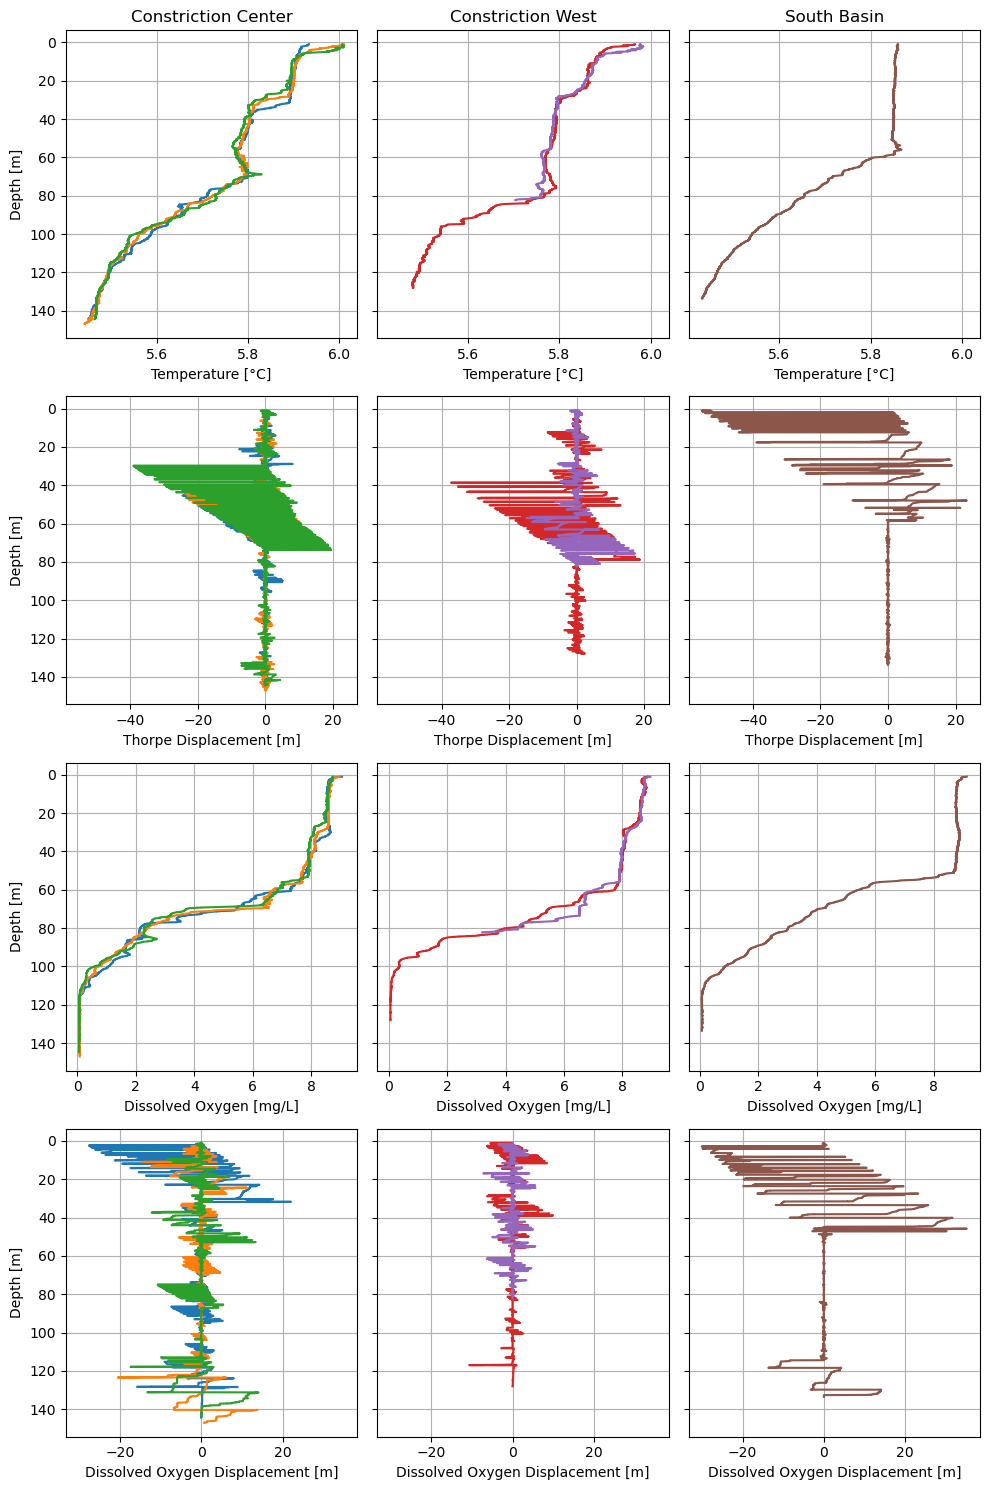

In [ ]:
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(10, 15), sharey=True, sharex='row')
palette = sns.color_palette('tab10', n_colors=6)

# VMPC
sns.lineplot(data.query("name == 'VMPC'"), x='temp', y='depth', orient='y', hue='time', palette=palette[:3], ax=ax[0, 0], legend=False)
sns.lineplot(data.query("name == 'VMPC'"), x='thorpe_displacement', y='depth', orient='y', hue='time', palette=palette[:3], ax=ax[1, 0], legend=False)
sns.lineplot(data.query("name == 'VMPC'"), x='do', y='depth', orient='y', hue='time', palette=palette[:3], ax=ax[2, 0], legend=False)
sns.lineplot(data.query("name == 'VMPC'"), x='do_displacement', y='depth', orient='y', palette=palette[:3], hue='time', ax=ax[3, 0], legend=False)

# VMPW
sns.lineplot(data.query("name == 'VMPW'"), x='temp', y='depth', orient='y', hue='time', palette=palette[3:5], ax=ax[0, 1], legend=False)
sns.lineplot(data.query("name == 'VMPW'"), x='thorpe_displacement', y='depth', orient='y', hue='time', palette=palette[3:5], ax=ax[1, 1], legend=False)
sns.lineplot(data.query("name == 'VMPW'"), x='do', y='depth', orient='y', hue='time', palette=palette[3:5], ax=ax[2, 1], legend=False)
sns.lineplot(data.query("name == 'VMPW'"), x='do_displacement', y='depth', orient='y', hue='time', palette=palette[3:5], ax=ax[3, 1], legend=False)

# VMPS
sns.lineplot(data.query("name == 'VMPS'"), x='temp', y='depth', orient='y', color=palette[-1], ax=ax[0, 2])
sns.lineplot(data.query("name == 'VMPS'"), x='thorpe_displacement', y='depth', orient='y', color=palette[-1], ax=ax[1, 2])
sns.lineplot(data.query("name == 'VMPS'"), x='do', y='depth', orient='y', color=palette[-1], ax=ax[2, 2])
sns.lineplot(data.query("name == 'VMPS'"), x='do_displacement', y='depth', orient='y', color=palette[-1], ax=ax[3, 2])

for i in range(ax.shape[0]):
    ax[i, 0].set_ylabel('Depth [m]')
    for j in range(ax.shape[1]):
        ax[0, j].set_xlabel('Temperature [°C]')
        ax[1, j].set_xlabel('Thorpe Displacement [m]')
        ax[2, j].set_xlabel('Dissolved Oxygen [mg/L]')
        ax[3, j].set_xlabel('Dissolved Oxygen Displacement [m]')
        ax[i, j].grid(True)

ax[0, 0].set_title('Constriction Center')
ax[0, 1].set_title('Constriction West')
ax[0, 2].set_title('South Basin')

ax[0,0].invert_yaxis()

plt.tight_layout()
plt.show()

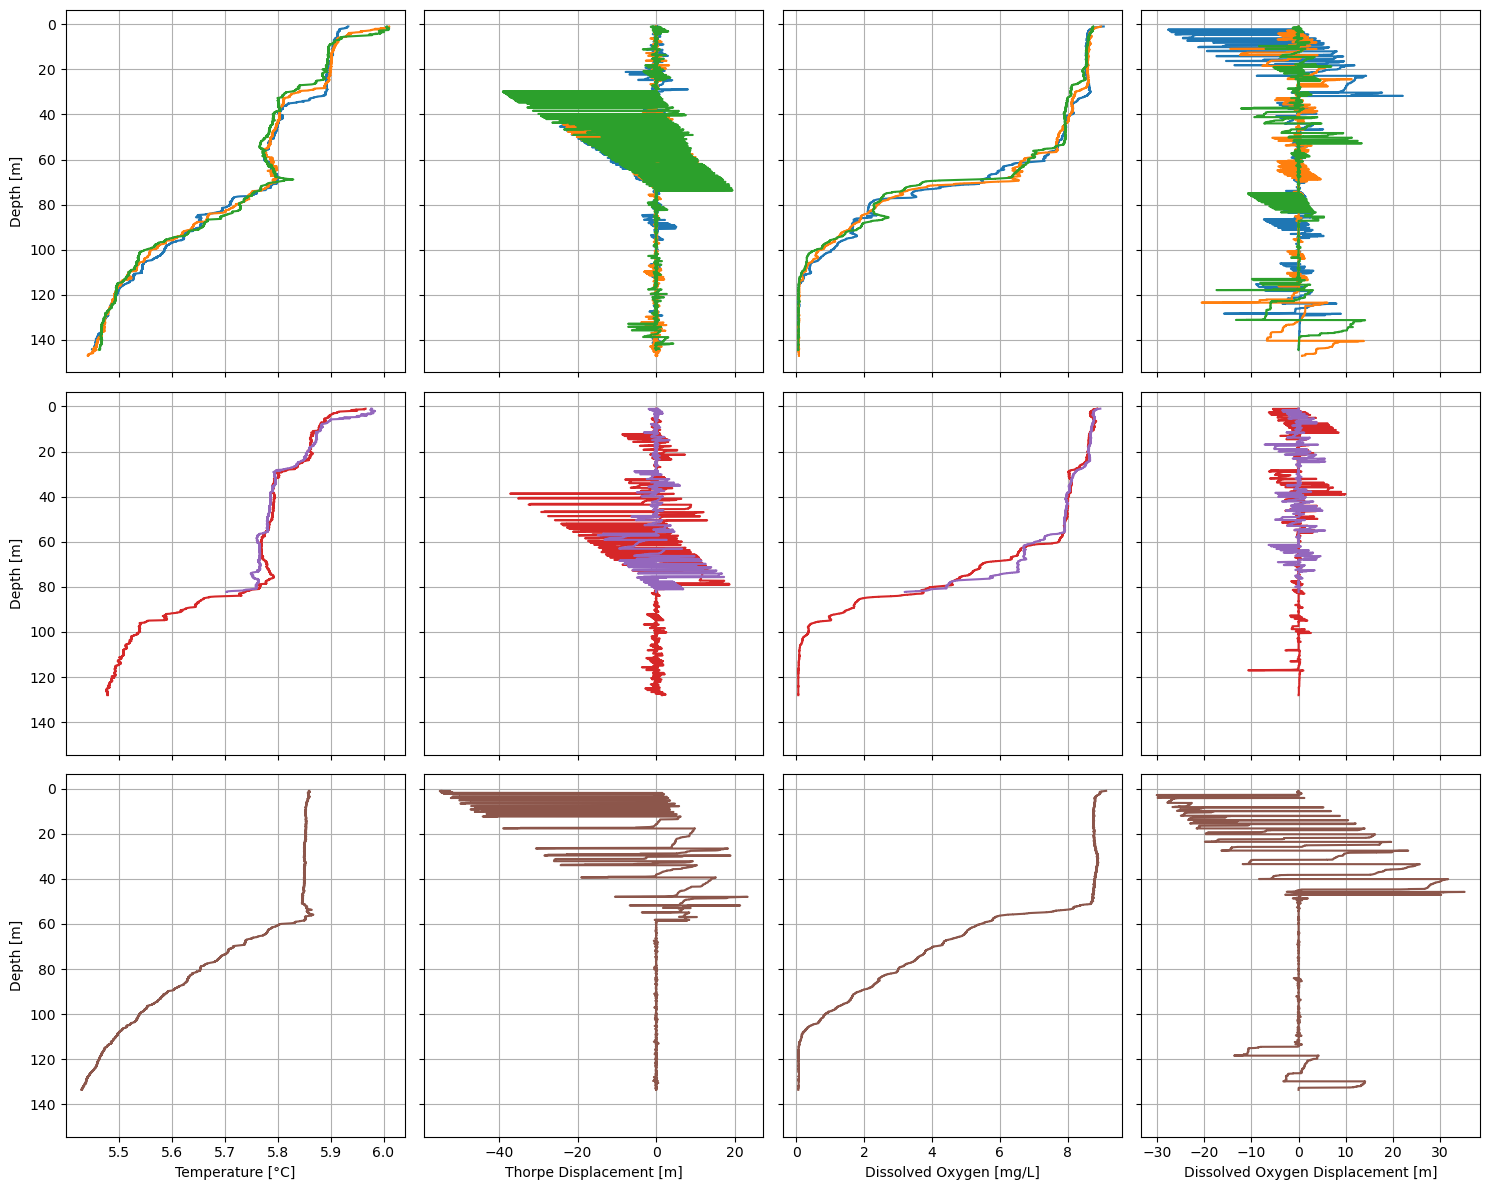

In [172]:
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(15, 12), sharey=True, sharex='col')
palette = sns.color_palette('tab10', n_colors=6)

# VMPC
sns.lineplot(data.query("name == 'VMPC'"), x='temp', y='depth', orient='y', hue='time', palette=palette[:3], ax=ax[0, 0], legend=False)
sns.lineplot(data.query("name == 'VMPC'"), x='thorpe_displacement', y='depth', orient='y', hue='time', palette=palette[:3], ax=ax[0, 1], legend=False)
sns.lineplot(data.query("name == 'VMPC'"), x='do', y='depth', orient='y', hue='time', palette=palette[:3], ax=ax[0, 2], legend=False)
sns.lineplot(data.query("name == 'VMPC'"), x='do_displacement', y='depth', orient='y', palette=palette[:3], hue='time', ax=ax[0, 3], legend=False)

# VMPW
sns.lineplot(data.query("name == 'VMPW'"), x='temp', y='depth', orient='y', hue='time', palette=palette[3:5], ax=ax[1, 0], legend=False)
sns.lineplot(data.query("name == 'VMPW'"), x='thorpe_displacement', y='depth', orient='y', hue='time', palette=palette[3:5], ax=ax[1, 1], legend=False)
sns.lineplot(data.query("name == 'VMPW'"), x='do', y='depth', orient='y', hue='time', palette=palette[3:5], ax=ax[1, 2], legend=False)
sns.lineplot(data.query("name == 'VMPW'"), x='do_displacement', y='depth', orient='y', hue='time', palette=palette[3:5], ax=ax[1, 3], legend=False)

# VMPS
sns.lineplot(data.query("name == 'VMPS'"), x='temp', y='depth', orient='y', color=palette[-1], ax=ax[2, 0])
sns.lineplot(data.query("name == 'VMPS'"), x='thorpe_displacement', y='depth', orient='y', color=palette[-1], ax=ax[2, 1])
sns.lineplot(data.query("name == 'VMPS'"), x='do', y='depth', orient='y', color=palette[-1], ax=ax[2, 2])
sns.lineplot(data.query("name == 'VMPS'"), x='do_displacement', y='depth', orient='y', color=palette[-1], ax=ax[2, 3])

for i in range(ax.shape[0]):
    ax[i, 0].set_ylabel('Depth [m]')
    for j in range(ax.shape[1]):
        ax[i, j].grid(True)

ax[2, 0].set_xlabel('Temperature [°C]')
ax[2, 1].set_xlabel('Thorpe Displacement [m]')
ax[2, 2].set_xlabel('Dissolved Oxygen [mg/L]')
ax[2, 3].set_xlabel('Dissolved Oxygen Displacement [m]')

ax[0,0].invert_yaxis()

plt.tight_layout()
plt.show()

#### RMS Displacement

For temperature, only consider region below thermocline.  For oxygen, only include hypolimnion to anoxic region.  Or just 85-105 meters.

In [176]:
rms_fxn = lambda x: np.sqrt((x**2).mean())
rms = data[data['depth'].between(85, 105)].groupby(['name', 'time']).agg({'thorpe_displacement': rms_fxn, 'do_displacement': rms_fxn}).reset_index()
rms

,name,time,thorpe_displacement,do_displacement
0,VMPC,12:15,1.387831,2.212028
1,VMPC,13:37,0.130859,0.513698
2,VMPC,16:23,0.313256,1.321642
3,VMPS,10:48,0.074484,0.111497
4,VMPW,14:20,0.679928,0.662550


In [180]:
dfm = pd.melt(rms, id_vars=['name', 'time'], value_vars=['thorpe_displacement', 'do_displacement'], var_name='label', value_name='displacement')

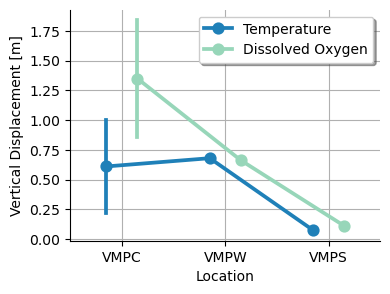

In [193]:
fig, ax = plt.subplots(figsize=(4, 3))

sns.pointplot(dfm, x='name', y='displacement', order=['VMPC', 'VMPW', 'VMPS'], hue='label', hue_order=['thorpe_displacement', 'do_displacement'],
               palette='YlGnBu_r', dodge=0.3, errorbar=('se', 1), ax=ax)

ax.set_xlabel('Location')
ax.set_ylabel('Vertical Displacement [m]')

ax.spines[['right', 'top']].set_visible(False)
ax.grid(True)
labels = ['Temperature', 'Dissolved Oxygen']
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, labels, shadow=True, fancybox=True)
plt.show()

In [194]:
serial_id = '1807'
lake = 'Zugersee'
year = '2026'
date = '20260107'

dpath_L1 = f'Q:/Messdaten/Aphys_Hypothesis_data/{lake}/{year}/CTD/{date}/L1'

In [195]:
data = []
for p in os.listdir(dpath_L1):
    fpath = os.path.join(dpath_L1, p)
    
    ctdreader = ewg.ctd_reader.CTDReader(lake, year, date, fpath, serial_id)
    bathy = ctdreader.load_bathymetry()
    ds = ctdreader.load_from_L1()

        # metadata
    name = ds.attrs['Profile name']
    time = ds.attrs['Time of measurement (local)']
    xsc = int(ds.attrs['X Coordinate (CH1903)']) + int(2e6)
    ysc = int(ds.attrs['Y Coordinate (CH1903)']) + int(1e6)
    total_depth = bathy.sel(xsc=xsc, ysc=ysc).depth.item()

    # data quality
    mask = (ds['depth'].notnull()) & (ds['Temp_qual'] == 0) & (ds['DO_mg_qual'] == 0)
    depth = ds['depth'][mask]
    temp = ds['Temp'][mask]
    do = ds['DO_mg'][mask]

    temp_sorted, depth_sorted = ewg.signal.order_profile(temp, depth, True)
    thorpe_displacement = depth.values - depth_sorted.values

    do_sorted, depth_sorted = ewg.signal.order_profile(do, depth, True)
    do_displacement = depth.values - depth_sorted.values

    dat = pd.DataFrame({
        'depth': depth.values,
        'temp': temp.values,
        'do': do.values,
        'temp_sorted': temp_sorted.values,
        'do_sorted': do_sorted.values,
        'thorpe_displacement': thorpe_displacement,
        'do_displacement': do_displacement
    })
    dat[['name', 'time', 'xsc', 'ysc', 'total_depth']] = name, time, xsc, ysc, total_depth
    data.append(dat)

data = pd.concat(data, ignore_index=True)

In [196]:
data = data.query("depth > 1")

In [198]:
rms_fxn = lambda x: np.sqrt((x**2).mean())
rms = data[data['depth'].between(85, 105)].groupby(['name', 'time']).agg({'thorpe_displacement': rms_fxn, 'do_displacement': rms_fxn}).reset_index()

dfm = pd.melt(rms, id_vars=['name', 'time'], value_vars=['thorpe_displacement', 'do_displacement'], var_name='label', value_name='displacement')

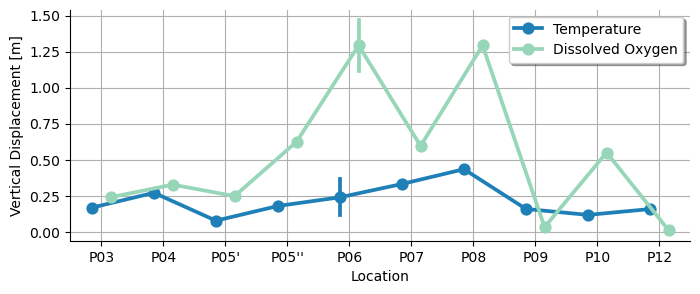

In [204]:
fig, ax = plt.subplots(figsize=(8, 3))

sns.pointplot(dfm, x='name', y='displacement', hue='label', hue_order=['thorpe_displacement', 'do_displacement'],
               palette='YlGnBu_r', dodge=0.3, errorbar=('se', 1), ax=ax)

ax.set_xlabel('Location')
ax.set_ylabel('Vertical Displacement [m]')

ax.spines[['right', 'top']].set_visible(False)
ax.grid(True)
labels = ['Temperature', 'Dissolved Oxygen']
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, labels, shadow=True, fancybox=True)
plt.show()